In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.6.0


In [12]:
df = pd.read_excel('/content/Dataset (2).xlsx',index_col=None)

# Removing the unnecessary columns.
df = df[['Comment','polarity']]

In [13]:
df.head()

,Comment,polarity
0,@ProFootballTalk Maybe we should stop keeping ...,2.0
1,So good I had to share! Check out all the item...,5.0
2,I’m New on Twitter do follow friends ❤️🥺 #foll...,3.0
3,Your favourite daily newspaper just added even...,3.0
4,@imKayrapolat @tsss67 @PurelyFootball That's b...,2.0


In [34]:
df.dropna(inplace=True)


Text(0.5, 1.0, 'Sentiment Data Distribution')

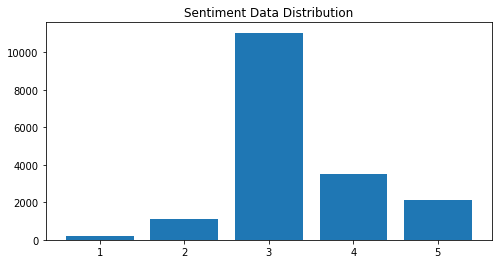

In [35]:
val_count = df.polarity.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

#Text preprocessing

In [36]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [37]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [38]:
df.Comment = df.Comment.apply(lambda x: preprocess(x))


In [39]:
df

,Comment,polarity
0,maybe stop keeping track records think meaning...,2.0
1,good share check items loving poshmarkapp posh...,5.0
2,new twitter follow friends follow newprofilepi...,3.0
3,favourite daily newspaper added even insight n...,3.0
4,tsss67 purelyfootball cancerous gloryhunter ho...,2.0
...,...,...
17995,call old fashion want simple wedding fancy hal...,3.0
17996,mention talking generation forced essentially ...,3.0
17997,drove south whitby covid test center see still...,3.0
17998,um 10 year old technology already,3.0


#Positive words

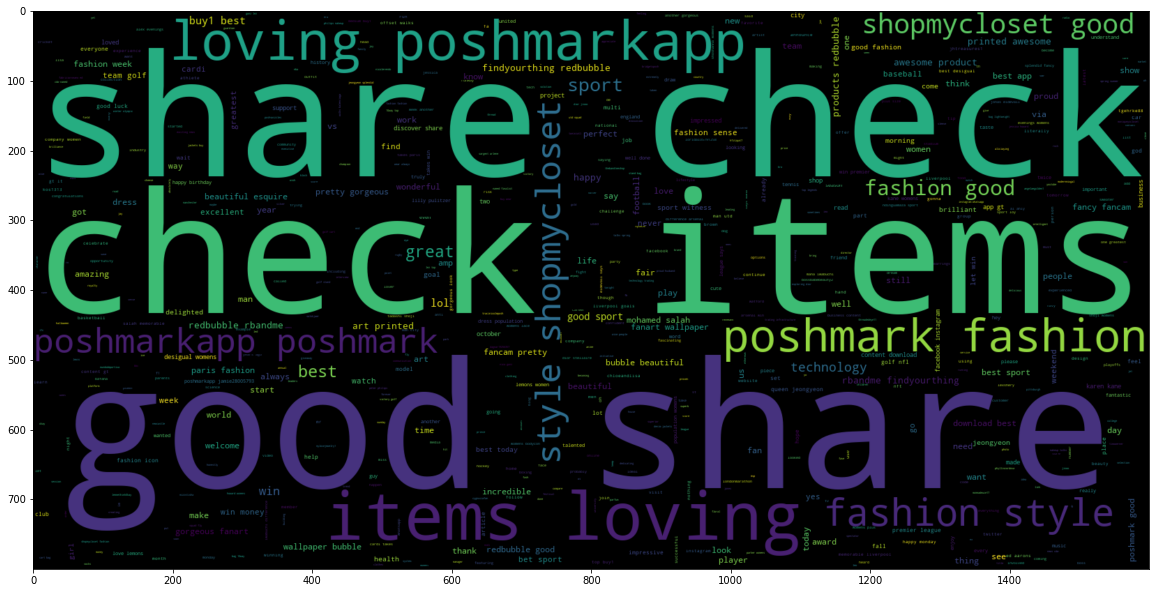

In [40]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.polarity == 5].Comment))
plt.imshow(wc , interpolation = 'bilinear')

#Negative words

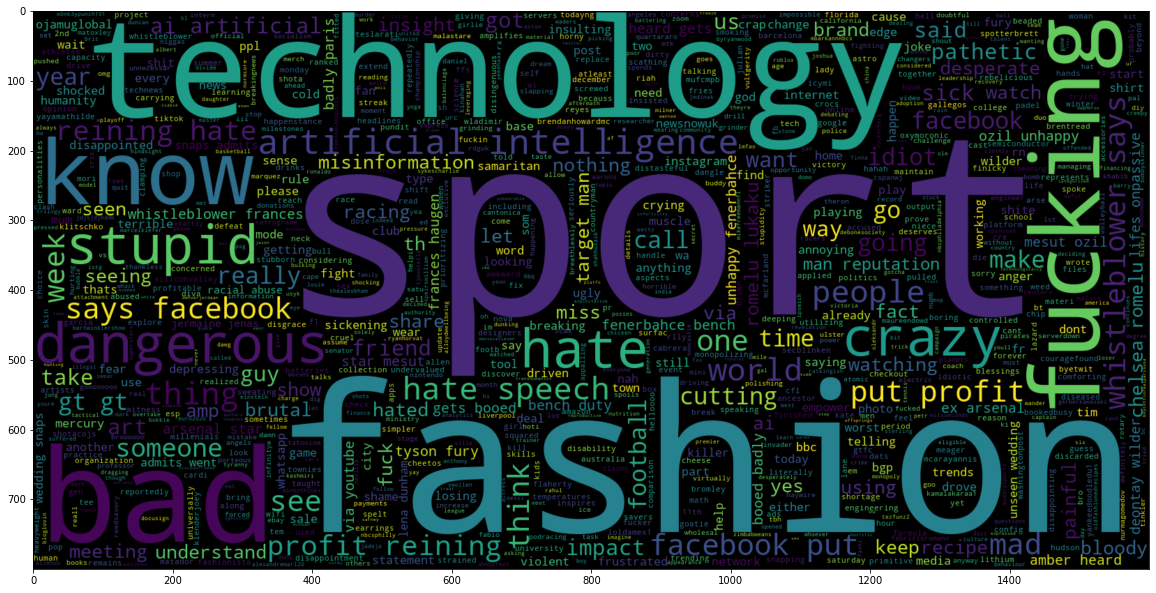

In [41]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.polarity == 1].Comment))
plt.imshow(wc , interpolation = 'bilinear')

# Train & test split

In [42]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [43]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 14360
Test Data size 3590


# Tokenization

In [44]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.Comment)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 24262


In [45]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Comment),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Comment),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (14360, 30)
Testing X Shape: (3590, 30)


In [46]:
labels = train_data.polarity.unique().tolist()

#Label encoding

In [47]:
encoder = LabelEncoder()
encoder.fit(train_data.polarity.to_list())

y_train = encoder.transform(train_data.polarity.to_list())
y_test = encoder.transform(test_data.polarity.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (14360, 1)
y_test shape: (3590, 1)


#Word embedding

In [48]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-10-11 16:52:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-11 16:52:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-11 16:52:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [49]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [50]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [51]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [52]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training LSTM

In [53]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [54]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [55]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [56]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [57]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
15/15 [==============================] - 43s 522ms/step - loss: -12.9977 - accuracy: 0.0571 - val_loss: -91.6977 - val_accuracy: 0.0591
Epoch 2/10
15/15 [==============================] - 7s 448ms/step - loss: -393.3193 - accuracy: 0.0607 - val_loss: -1080.7981 - val_accuracy: 0.0591
Epoch 3/10
15/15 [==============================] - 7s 453ms/step - loss: -2292.7644 - accuracy: 0.0607 - val_loss: -4471.6875 - val_accuracy: 0.0591
Epoch 4/10
15/15 [==============================] - 7s 443ms/step - loss: -7520.4434 - accuracy: 0.0607 - val_loss: -12280.2227 - val_accuracy: 0.0591
Epoch 5/10
15/15 [==============================] - 7s 463ms/step - loss: -18308.1113 - accuracy: 0.0607 - val_loss: -27015.2422 - val_accuracy: 0.0591
Epoch 6/10
15/15 [==============================] - 7s 464ms/step - loss: -37340.2930 - accuracy: 0.0607 - val_loss: -51639.3359 - val_accuracy: 0.0591
Epoch 7/10
15/15 [==============================] - 7s 448ms/step - loss: -68127.9297 - accuracy: 0

#Model Evaluation

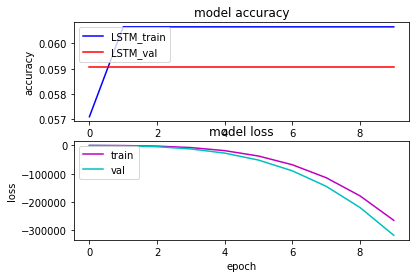

In [58]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')